# Finding Heavy Traffic Indicators on I-94

The goal of our analysis is to determine what factors influence heavy traffic on I-94. We'll look at different indicators such as weather, time of day, time of year, etc. to see if we can find a correlation between these conditions and traffic. The traffic data was recorded hourly by a station located approximately midway between Minneapolis and Saint Paul in Minnesota. The station only records westbound traffic (cars moving from east to west).

The dataset can be downloaded: [here]('https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

## Explore Data 

In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We have nearly 6 years of data: 10-2-2012 to 9-30-2018

In [4]:
traffic.head(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516


In [5]:
traffic.tail(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


The below histogram shows: on one end there's a high frequency of low traffic volume (0-500 vehicles per hour) and on the other end there's high frequency of high traffic volume (4500-5000 vehicles per hour). We can speculate that a reason for this might be time of day. Normally, there is less vehicles on the during the night time vs during the day.

Text(0.5, 0, 'Traffic Volume')

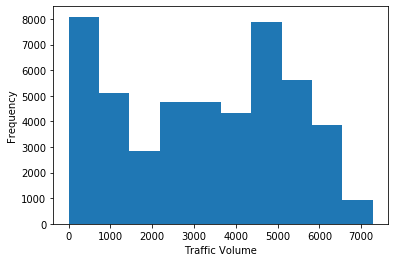

In [6]:
traffic['traffic_volume'].plot.hist()
plt.xlabel('Traffic Volume')

In [7]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

## Comparing Daytime and Nighttime Traffic

In [8]:
#convert date_time column to datetime object
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

To compare daytime and nighttime we'll need to split our dataset up. We'll consider daytime to be between 7:00am and 7:00pm and nighttime to be 7:00pm to 7:00am so we have a 12 hour timeframe for each.

In [9]:
daytime = traffic[traffic['date_time'].dt.hour.between(7,18)]
daytime.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [10]:
nighttime = traffic[(traffic['date_time'].dt.hour < 7) | (traffic['date_time'].dt.hour > 18)]
nighttime.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361


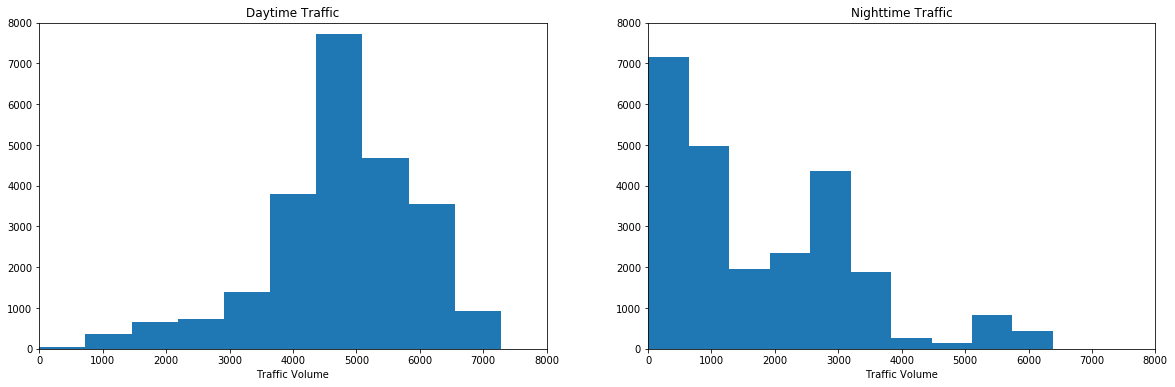

In [11]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.hist(daytime['traffic_volume'])
plt.xlim([0, 8000])
plt.ylim([0, 8000])
plt.xlabel('Traffic Volume')
plt.title('Daytime Traffic')

plt.subplot(1,2,2)
plt.hist(nighttime['traffic_volume'])
plt.xlim([0, 8000])
plt.ylim([0, 8000])
plt.xlabel('Traffic Volume')
plt.title('Nighttime Traffic')

plt.show()

There is much higher traffic volume in the daytime vs nighttime. Comparing the two histograms above, the daytime has more of a left skew vs more of a right skew for the nighttime. There's 4,762 vehicles on average during the daytime hours compared to 1,785 vehicles on average for nighttime. Since our goal is to look for high traffic indicators, we'll turn our focus to the daytime dataset.

In [12]:
daytime['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [13]:
nighttime['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

## Taking a Closer Look at Daytime Traffic

Looking specifically at daytime traffic, we first want to look at traffic volume by month to see if there are any months out of the year that tend to have a higher volume.
### Traffic by Month

In [14]:
pd.options.mode.chained_assignment = None
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()

by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

There appears to be less traffic in the winter months. We see the lowest traffic volume in December (4,374), followed closely by January (4,495). Volume increases in February (4,711) and November (4,704). From March to October it's higher, remaining right around 4,900 besides a dip in July (4,595). I would expect the lower traffic in the winter months but the big dip in July comes as somewhat of a surpise.

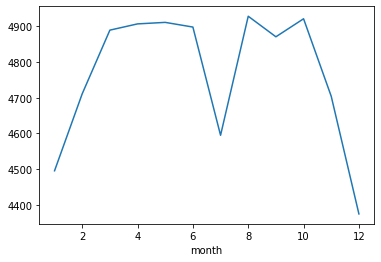

In [15]:
by_month['traffic_volume'].plot.line()

### Traffic by Day of Week

Below we see traffic volume by day of the week (0 = Monday, 6 = Sunday). There is a big drop off in traffic volume on the weekends. Besides traffic volume being slightly lower on Monday (\~4,875), it's stagnant Tuesday-Friday (\~5,200). We see a big drop on Saturday to under 4,000 and then it drops even further Sunday to under 3,500.

My assumption would be that traffic volume is higher on weekday because people are traveling to and from work. Below we'll take a closer look at traffic on weekdays vs weekends.

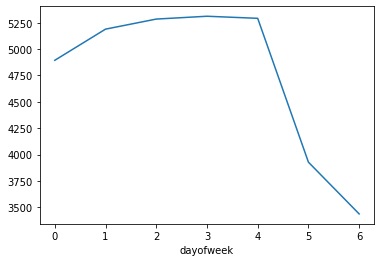

In [16]:
daytime['dayofweek'] = daytime['date_time'].dt.dayofweek
by_day = daytime.groupby('dayofweek').mean()

by_day['traffic_volume'].plot.line()

### Time Indicators

Below we split our dataset to isolate business days (Mon-Fri) and weekends (Sat-Sun). We'll take the mean traffic volume for each hour of the day to compare what time of day has peak traffic volume for both business days and weekends.

In [17]:
daytime['hour'] = daytime['date_time'].dt.hour
business_day = daytime.copy()[daytime['dayofweek'] <= 4] 
weekend = daytime.copy()[daytime['dayofweek'] >= 5] 

business_by_hour = business_day.groupby('hour').mean()
weekend_by_hour = weekend.groupby('hour').mean()

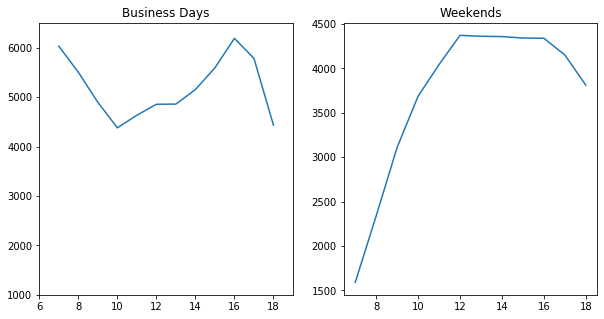

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(business_by_hour['traffic_volume'])
plt.xlim([6,19])
plt.ylim([1000, 6500])
plt.title('Business Days')

plt.subplot(1,2,2)
plt.plot(weekend_by_hour['traffic_volume'])
plt.title('Weekends')

plt.show()

For business days, traffic peaks at 7:00am and 4:00pm. This aligns with are previous assumption about traffic volume being driven by people driving to and from work. On the weekends we see the highest traffic volume between 12:00pm and 4:00pm. The max traffic volume for the weekends is just slightly higher than the minimum traffic volume seen on business days.

### Weather Impacts on Traffic

Below we found the correlation values between the numerical weather columns and traffic volume. Temperature seems to have the strongest correlation of the 4 but even that has a very week correlation.

In [19]:
num_weather_col = traffic.columns[1:5]

for col in num_weather_col:
    print(col + ': ' + str(daytime['traffic_volume'].corr(daytime[col])))

temp: 0.12831656852303916
rain_1h: 0.003696509835073433
snow_1h: 0.0012653498471759833
clouds_all: -0.03293234866163949


In [20]:
# convert temperature from Kelvin to Fahrenheit
daytime['temp_F'] = daytime['temp'].apply(lambda x: (9/5)*(x - 273) + 32)

Text(0.5, 1.0, 'Traffic Volume and Temperature')

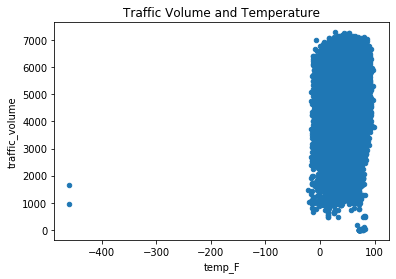

In [21]:
daytime.plot.scatter(x='temp_F',
                    y='traffic_volume')
plt.title('Traffic Volume and Temperature')

There are two rows where the temperature is listed as 0 degrees Kelvin which equates to -459.4 degrees Fahrenheit. This isn't possible. Since there's only two rows, we'll drop these from the dataset.

In [22]:
daytime[daytime['temp'] == daytime['temp'].min()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,dayofweek,hour,temp_F
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962,2,6,7,-459.4
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670,2,6,8,-459.4


In [23]:
# drop rows
daytime.drop([11950,11951], inplace=True)

Text(0.5, 1.0, 'Traffic Volume and Temperature')

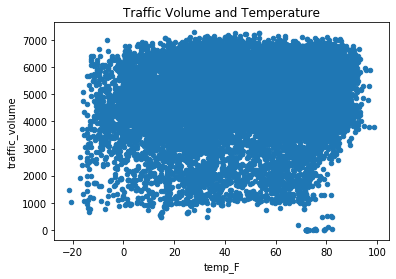

In [24]:
# traffic volume and Temp scatter plot after dropping rows
daytime.plot.scatter(x='temp_F',
                    y='traffic_volume')
plt.title('Traffic Volume and Temperature')

The above scatter plot confirms no correlation between traffic volume and temperature. 

We'll expore weather_main and weather_description columns below. These columns are categorical columns describing the weather textually.

In [25]:
# average daytime traffic volume
daytime['traffic_volume'].describe()

count    23875.000000
mean      4762.336126
std       1174.167620
min          0.000000
25%       4253.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [26]:
# grouping dataset by weather_main and weather_description columns
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_description = daytime.groupby('weather_description').mean()

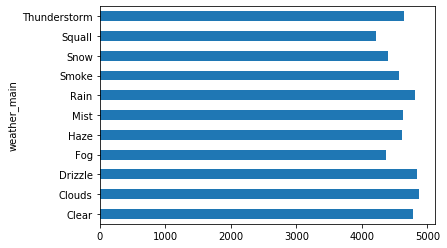

In [27]:
# average traffic volume by weather main column
by_weather_main['traffic_volume'].plot.barh()

We don't see a ton of variation from the different weather categories in the weather_main column. Squall (windy) and Fog have the lowest traffic volume while Clouds and Drizzle have the highest. However, there's none of the categories reach substantially beyond the mean traffic volume of our daytime dataset (4,762).

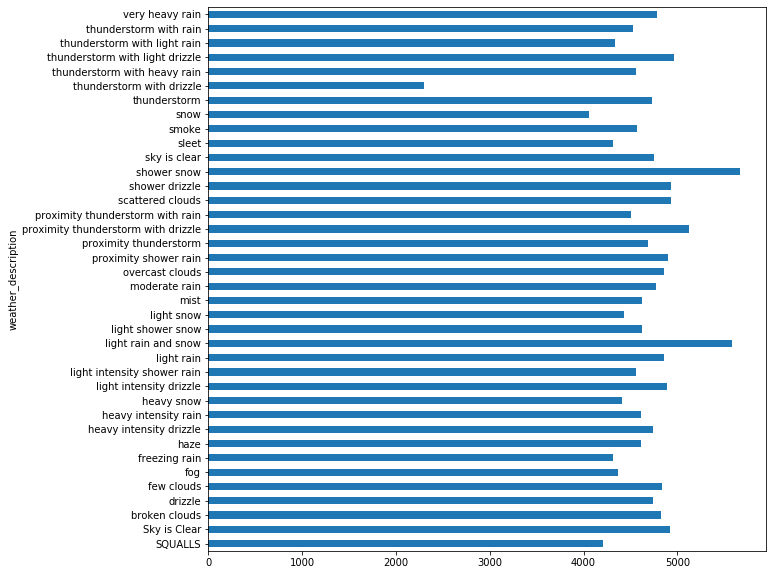

In [28]:
# average traffic volume by weather description column
by_weather_description['traffic_volume'].plot.barh(figsize=(10,10))

We see a bit more variation with traffic volume for the weather_description column compared to weather_main.

In [29]:
by_weather_description['traffic_volume'].sort_values(ascending=False).head(3)

weather_description
shower snow                            5664.000000
light rain and snow                    5579.750000
proximity thunderstorm with drizzle    5121.833333
Name: traffic_volume, dtype: float64

Weather types: shower snow, light rain and snow, and proximity thunderstorm with drizzle seem to be have high traffic volume with traffic volume with averages above 5,000 vehicles per hour.

## Conclusion

Through the completion of this project, we were able to understand traffic trends and identify high traffic indicators on I-94 between Minneapolis and St. Paul, MN. In summary, higher traffic volume can be expected:  
* In warmer months (March-October), with the exception of July, compared to colder months (November-February)
* During the day (7:00am - 7:00pm) compared to the night (7:00pm - 7:00am) 
* On business days (Mon-Fri) compared to weekends (Sat-Sun)
    - Traffic peaks at 7:00am and 4:00pm on business days
* With weather conditions: shower snow, light rain and snow, proximity thunderstorm with drizzle